In [7]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow import keras

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


(262, 350, 3)
(409, 336, 3)
(493, 500, 3)
(375, 500, 3)
(240, 320, 3)
(100, 100, 3)
(216, 182, 3)
(375, 500, 3)
(377, 500, 3)


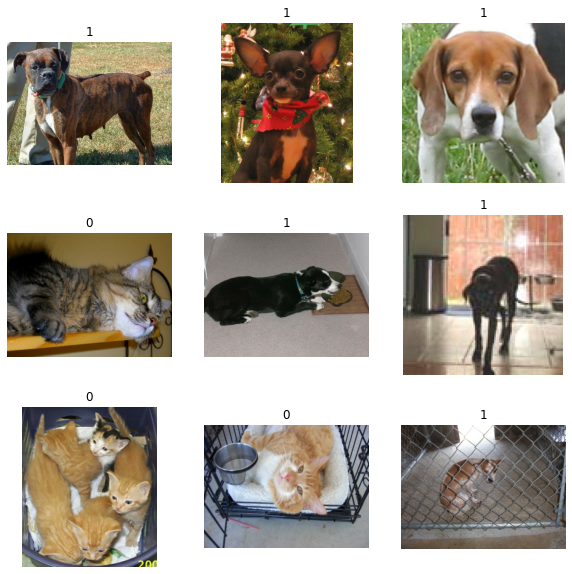

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    print(image.shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [9]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [10]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

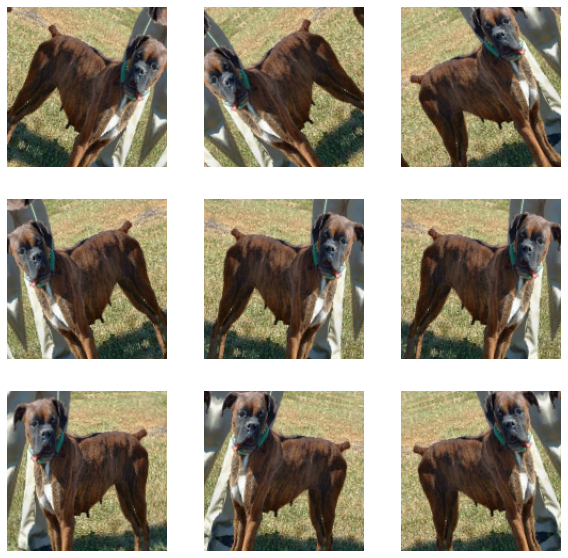

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [15]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(x)
norm_layer.set_weights([mean, var])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 33s 82ms/step - loss: 0.2296 - binary_accuracy: 0.8951 - val_loss: 0.0843 - val_binary_accuracy: 0.9695
Epoch 2/20
291/291 [==============================] - 23s 78ms/step - loss: 0.1215 - binary_accuracy: 0.9499 - val_loss: 0.0751 - val_binary_accuracy: 0.9716
Epoch 3/20
291/291 [==============================] - 22s 77ms/step - loss: 0.1065 - binary_accuracy: 0.9524 - val_loss: 0.0764 - val_binary_accuracy: 0.9690
Epoch 4/20
291/291 [==============================] - 22s 76ms/step - loss: 0.1029 - binary_accuracy: 0.9607 - val_loss: 0.0729 - val_binary_accuracy: 0.9725
Epoch 5/20
291/291 [==============================] - 22s 77ms/step - loss: 0.1054 - binary_accuracy: 0.9569 - val_loss: 0.0740 - val_binary_accuracy: 0.9721
Epoch 6/20
291/291 [==============================] - 22s 77ms/step - loss: 0.1032 - binary_accuracy: 0.9561 - val_loss: 0.0706 - val_binary_accuracy: 0.9725
Epoch 7/20
291/291 [==============================] 

In [18]:
score = model.evaluate(test_ds, verbose=0)

In [19]:
print(score)

[0.07707957178354263, 0.9737747311592102]
